In [8]:
push!(LOAD_PATH, pwd())
#include("FCV.jl")
using FCV
using Plots, LinearAlgebra, Random
rng = MersenneTwister(7);

# Initialization

In [12]:
d = 2
N = 2^10
M = N
s = 3
What = [ abs(norm(freq)+1).^s for freq in Iterators.product(ntuple(x -> -N/2:N/2-1, d)...) ] |> vec
nodes = Iterators.product(ntuple(x -> (-N/2:N/2-1)/N, d)...)
function peaks(x, y) # peaks sample function from matlab
  x *= 6
  y *= 6
  z = 3*(1-x)^2*exp(-(x^2) - (y+1)^2) -
    10*(x/5 - x^3 - y^5)*exp(-x^2-y^2) -
    1/3*exp(-(x+1)^2 - y^2) 
  return z
end
fun = (x, y) -> peaks(x, y)
f = [ fun(n...) for n in nodes ] |> vec

sigma = 0.1
f_e = f+sigma*(maximum(f)-minimum(f))*randn(rng, size(f))

lambda = [ exp(t) for t in range(-12,-6, length = 25) ]
cv = similar(lambda)
l2err = similar(lambda)

@time fcv = fcv_t_equispaced(2, f_e);

  0.026442 seconds (61 allocations: 48.003 MiB, 38.60% gc time)


# Computations

In [13]:
@time for i in eachindex(lambda)
    res = compute(fcv, lambda[i]*What)
    cv[i] = res.gcv
    l2err[i] = 1/M*norm(f-res.f_r)
end

res = compute(fcv, lambda[argmin(cv)]*What);

  3.155614 seconds (5.70 k allocations: 4.688 GiB, 4.32% gc time)


# Plotting

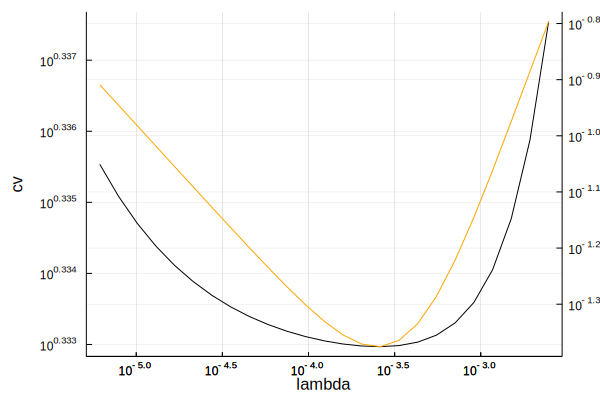

In [14]:
plot(lambda, cv,
  color = :black,
  axis = (:log10),
  xlabel = "lambda",
  ylabel = "cv",
  legend = :none)
plot!(twinx(), lambda, l2err,
  color = :orange,
  legend = :none,
  axis = (:log10),
  ylabel = "l2err",
  guidefontcolor = :orange)

In [15]:
p_noisy = heatmap(
(-N/2:N/2-1)/N,
(-N/2:N/2-1)/N,
reshape(f_e, N, N),
title = "noisy data",
aspect_ratio = :equal)

p_reconstruction = heatmap(
(-N/2:N/2-1)/N,
(-N/2:N/2-1)/N,
reshape(real(res.f_r), N, N),
title = "reconstruction",
aspect_ratio = :equal)

plot(p_noisy, p_reconstruction)